In [1]:
import openmc
import openmc.deplete # will be needed for depletion analysis eventually
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Create the assembly-cell model

### Materials

In [2]:
# materials

NpO2 = openmc.Material();
NpO2.add_nuclide('Np237',1);
NpO2.add_nuclide('Pu238',1e-14); #add a trace amount of Pu-238 so I can add a Pu-238 tally in the target from the begining.
NpO2.add_nuclide('Np238',1e-14); # ditto...
NpO2.add_element('O',2);
NpO2.set_density('g/cc',11.143);

Al = openmc.Material();
Al.add_element('Al',1);
Al.set_density('g/cc',2.7);


target = openmc.Material.mix_materials([NpO2,Al],[0.2,0.7],'vo',
                                      name='target'); 
target.depletable = True
# note: 10% is void so expect to get a UserWarning on this.


# materials for fuel pin
uo2 = openmc.Material(name='UO2')
uo2.add_element('U',1.0, enrichment=5.0)
uo2.add_element('O',2.0)
uo2.set_density('g/cc',10.45)
uo2.depletable = True

# cladding

# based on PNNL-15870 Rev 1. 
zirc4 = openmc.Material(name='Zirc-4')
zirc4.add_element('O',0.006790); # by default add_element in atom fraction.
zirc4.add_element('Cr',0.001741);
zirc4.add_element('Fe',0.003242);
zirc4.add_element('Zr',0.977549);
zirc4.add_element('Sn',0.010677);
zirc4.set_density('g/cc',6.56);

# gap will be modeled as a void

water = openmc.Material(name='Water')
water.set_density('g/cc',0.76);
water.add_element('H',2);
water.add_element('O',1);
water.add_s_alpha_beta('c_H_in_H2O');




/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/material.py:1177: UserWarning: Warning: sum of fractions do not add to 1, void fraction set to 0.10000000000000009
  warnings.warn(msg)


### Geometry

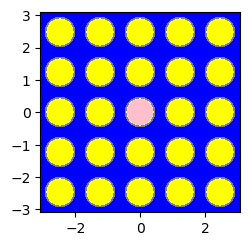

In [3]:
# create the surfaces

r_fo = 0.4096 # cm, fuel outer radius
r_ci = 0.4179 # cm, clad inner radius
r_co = 0.4751 # cm, clad outer radius

fuel_outer_radius = openmc.ZCylinder(r=r_fo);
clad_inner_radius = openmc.ZCylinder(r=r_ci);
clad_outer_radius = openmc.ZCylinder(r=r_co);

# define the regions

fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius
coolant_region = +clad_outer_radius

# define cells for a universe containing a fuel (UO2) pin

fuel = openmc.Cell(name='fuel');
fuel.fill = uo2;
fuel.region = fuel_region;

gap_f = openmc.Cell(name='gap_f');
gap_f.region = gap_region;
# no fill.  Makes it void by default

clad_f = openmc.Cell(name='clad_f');
clad_f.fill = zirc4;
clad_f.region = clad_region

coolant_f = openmc.Cell(name='coolant_f');
coolant_f.fill = water;
coolant_f.region = coolant_region;

# define the fuel pin universe

fp = openmc.Universe()
fp.add_cells([fuel,gap_f,clad_f,coolant_f]);

# define cells for a target pin universe

fuel_t = openmc.Cell(name='fuel_t');
fuel_t.region = fuel_region;
fuel_t.fill = target

gap_t = openmc.Cell(name='gap_t');
gap_t.region = gap_region;

clad_t = openmc.Cell(name='clad_t');
clad_t.fill = zirc4
clad_t.region = clad_region;

coolant_t = openmc.Cell(name='coolant_t');
coolant_t.fill = water
coolant_t.region = coolant_region 

tp = openmc.Universe()
tp.add_cells([fuel_t,gap_t,clad_t,coolant_t]);

# We also want to define an "all coolant" universe to use with the lattice we will be making.

all_coolant_cell = openmc.Cell(name='all_coolant_cell')
all_coolant_cell.fill = water
# with no region, water will just be everywhere (I think!!)

cu = openmc.Universe()
cu.add_cells([all_coolant_cell]);

# create the assembly/core geometry

P_D = 1.3     # pitch/diameter ratio
N_assy = 5; # number of pins per dimension in the assembly, i.e. N_assy x N_assy 

pitch = r_co*2.*P_D; # cm, pin pitch
a_pitch = N_assy*pitch # cm, assembly pitch

h_assy = 100; # cm, height of the assembly model

assy_box = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -h_assy/2.,h_assy/2.,
                                                  boundary_type='reflective');
# other boundary types = 'periodic' and 'vacuum'

assy_lat = openmc.RectLattice()
assy_lat.center = (0.,0.)
assy_lat.dimension = [N_assy,N_assy]
assy_lat.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
assy_lat.pitch = [pitch,pitch]
assy_lat.universes=[
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, tp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp]
]
assy_lat.outer = cu; # coolant universe is outside of the assy lattice.

assy_u = openmc.Universe()
assy_cell = openmc.Cell()
assy_cell.fill = assy_lat;
assy_cell.region = -assy_box
assy_u.add_cell(assy_cell);

# define a colors dictionary so we can tell OpenMC how to color our plots
colors = {}
colors[water]='blue';
colors[uo2]='yellow';
colors[zirc4]='gray';
colors[target]='pink';

# plot the assembly universe and make sure it looks right.
assy_u.plot(width=(a_pitch,a_pitch),color_by='material',colors=colors)

In [4]:
# create the geometry and export to XML

geometry = openmc.Geometry()
geometry.root_universe = assy_u

geometry.export_to_xml()

# Add volume calculation to materials and write materials to xml

# volume calc for target:
num_tgt_pins = 1;
num_fuel_pins = 24;
target.volume = np.pi*(r_fo**2)*h_assy*num_tgt_pins
uo2.volume = np.pi*(r_fo**2)*h_assy*num_fuel_pins

materials = openmc.Materials([target, uo2, zirc4, water]);
materials.export_to_xml();

### Tallies

In [5]:
# filters for energy, cells, and reactions
cell_filter = openmc.CellFilter(fuel_t); # measure in the target material cell

cell_filter_assy = openmc.CellFilter(assy_cell);

# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# avg flux for the whole core
flux_avg = openmc.Tally(name='avg flux')
flux_avg.scores = ['flux'];
flux_avg.filters = [cell_filter_assy, energy_filter];



# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

# tally fission in Np238
np238_fission_t = openmc.Tally(name='Np238_fiss')
np238_fission_t.scores = ['fission']
np238_fission_t.nuclides = ['Np238']
np238_fission_t.filters = [cell_filter,efilter_capture]

# tally (n,2n) in Np237
np237_n2n_t = openmc.Tally(name='Np237_n2n')
np237_n2n_t.scores = ['(n,2n)']
np237_n2n_t.nuclides = ['Np237']
np237_n2n_t.filters = [cell_filter]


# tally fission in Pu-238
pu238_fission_t = openmc.Tally(name='Pu238_fiss')
pu238_fission_t.scores = ['fission']
pu238_fission_t.nuclides = ['Pu238']
pu238_fission_t.filters = [cell_filter]

# tally (n,gamma) in Pu-238
pu238_capture_t = openmc.Tally(name='Pu238_capture')
pu238_capture_t.scores = ['(n,gamma)']
pu238_capture_t.nuclides = ['Pu238']
pu238_capture_t.filters = [cell_filter]

tallies = openmc.Tallies([flux_avg, flux_target, np237_capture_t, np237_n2n_t,
                         np238_fission_t, pu238_fission_t, pu238_capture_t]);
tallies.export_to_xml()

In [6]:
# create settings for criticality

settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-a_pitch/2.,-a_pitch/2.,-h_assy/2.),
                      upper_right=(a_pitch/2.,a_pitch/2.,h_assy/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src;

settings.export_to_xml();

## Conduct Depletion Calculation

In [ ]:
model = openmc.model.Model(geometry,materials,settings,tallies)
operator = openmc.deplete.CoupledOperator(model,"chain_casl_pwr.xml");

# Typical PWR power_density = 30.5 W/gHM
power_density = 30.5; # W/gHM
days = 24*3600;
time_steps = [0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.5*days, 0.5*days,
              1.0*days, 1.0*days, 1.0*days, 1.0*days, 4.0*days, 4.0*days, 
              4.0*days, 4.0*days,4.0*days, 4*days, 4*days, 4*days,4*days];

cecm = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density);


repeat_depletion = True;

if(repeat_depletion):
    cecm.integrate()



                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd106.h5
 Reading Pd107 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd107.h5
 Reading Pd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd108.h5
 Reading Ag107 from /home/sblair/OMC_DATA/

 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5


          1200K
          2500K


 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce143.h5
 Reading Ce144 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce144.h5
 Reading Pr141 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr141.h5
 Reading Pr142 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr142.h5
 Reading Pr143 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr143.h5
 Reading Nd142 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd142.h5
 Reading Nd143 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd143.h5
 Reading Nd144 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd144.h5
 Reading Nd145 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd145.h5
 Reading Nd146 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd146.h5
 Reading Nd147 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy163.h5
 Reading Dy164 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy164.h5
 Reading Ho165 from /home/sblair/OMC_DATA/endfb71_hdf5/Ho165.h5
 Reading Er162 from /home/sblair/OMC_DAT

      112/1    1.33431    1.34749 +/- 0.00147
      113/1    1.35622    1.34763 +/- 0.00145
      114/1    1.34833    1.34764 +/- 0.00143
      115/1    1.35891    1.34782 +/- 0.00142
      116/1    1.35546    1.34793 +/- 0.00140
      117/1    1.35615    1.34806 +/- 0.00138
      118/1    1.35061    1.34809 +/- 0.00136
      119/1    1.35719    1.34822 +/- 0.00135
      120/1    1.34797    1.34822 +/- 0.00133
      121/1    1.34038    1.34811 +/- 0.00132
      122/1    1.35330    1.34818 +/- 0.00130
      123/1    1.34725    1.34817 +/- 0.00128
      124/1    1.34466    1.34812 +/- 0.00127
      125/1    1.35029    1.34815 +/- 0.00125
      126/1    1.34131    1.34806 +/- 0.00124
      127/1    1.35262    1.34812 +/- 0.00122
      128/1    1.34524    1.34808 +/- 0.00121
      129/1    1.36651    1.34832 +/- 0.00121
      130/1    1.34122    1.34823 +/- 0.00120
      131/1    1.32438    1.34793 +/- 0.00122
      132/1    1.35109    1.34797 +/- 0.00121
      133/1    1.37400    1.34829 

       81/1    1.34456    1.34684 +/- 0.00198
       82/1    1.32956    1.34630 +/- 0.00199
       83/1    1.34646    1.34631 +/- 0.00193
       84/1    1.34384    1.34624 +/- 0.00187
       85/1    1.34690    1.34625 +/- 0.00182
       86/1    1.32550    1.34568 +/- 0.00186
       87/1    1.33660    1.34543 +/- 0.00182
       88/1    1.34310    1.34537 +/- 0.00178
       89/1    1.34904    1.34547 +/- 0.00173
       90/1    1.34337    1.34541 +/- 0.00169
       91/1    1.34241    1.34534 +/- 0.00165
       92/1    1.32868    1.34494 +/- 0.00166
       93/1    1.34525    1.34495 +/- 0.00162
       94/1    1.33119    1.34464 +/- 0.00161
       95/1    1.36762    1.34515 +/- 0.00166
       96/1    1.34123    1.34506 +/- 0.00162
       97/1    1.33418    1.34483 +/- 0.00160
       98/1    1.33159    1.34456 +/- 0.00160
       99/1    1.33661    1.34439 +/- 0.00157
      100/1    1.34199    1.34435 +/- 0.00154
      101/1    1.34094    1.34428 +/- 0.00151
      102/1    1.35451    1.34448 

       47/1    1.34606
       48/1    1.34549
       49/1    1.32522
       50/1    1.34039
       51/1    1.34157
       52/1    1.34076    1.34117 +/- 0.00040
       53/1    1.33768    1.34001 +/- 0.00119
       54/1    1.33230    1.33808 +/- 0.00210
       55/1    1.34869    1.34020 +/- 0.00267
       56/1    1.32486    1.33764 +/- 0.00336
       57/1    1.31269    1.33408 +/- 0.00456
       58/1    1.32312    1.33271 +/- 0.00418
       59/1    1.35003    1.33463 +/- 0.00416
       60/1    1.33976    1.33515 +/- 0.00375
       61/1    1.32753    1.33445 +/- 0.00347
       62/1    1.31928    1.33319 +/- 0.00341
       63/1    1.32711    1.33272 +/- 0.00317
       64/1    1.32426    1.33212 +/- 0.00300
       65/1    1.33477    1.33229 +/- 0.00279
       66/1    1.35504    1.33372 +/- 0.00298
       67/1    1.33657    1.33388 +/- 0.00280
       68/1    1.34591    1.33455 +/- 0.00272
       69/1    1.37823    1.33685 +/- 0.00345
       70/1    1.34833    1.33742 +/- 0.00333
       71/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.35969
        2/1    1.34743
        3/1    1.32983
        4/1    1.32399
        5/1    1.32546
        6/1    1.35438
        7/1    1.31162
        8/1    1.32713
        9/1    1.33989
       10/1    1.33851
       11/1    1.33770
       12/1    1.33073
       13/1    1.33073
       14/1    1.35008
       15/1    1.34113
       16/1    1.32629
       17/1    1.34295
       18/1    1.32383
       19/1    1.34425
       20/1    1.32198
       21/1    1.33357
       22/1    1.33337
       23/1    1.32332
       24/1    1.33197
       25/1    1.34579
       26/1    1.33072
       27/1    1.33745
       28/1    1.31563
       29/1    1.34660
       30/1    1.34373
       31/1    1.31315
       32/1    1.34390
       3

      200/1    1.32939    1.33277 +/- 0.00098
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8753e+02 seconds
   Time in transport only          = 2.8597e+02 seconds
   Time in inactive batches        = 4.5155e+01 seconds
   Time in active batches          = 2.4237e+02 seconds
   Time synchronizing fission bank = 4.7207e-01 seconds
     Sampling source sites         = 4.2227e-01 seconds
     SEND/RECV source sites        = 4.8508e-02 seconds
   Time accumulating tallies       = 8.1783e-01 seconds
   Time writing statepoints        = 2.8536e-02 seconds
 Total time for finalization       = 2.7470e-03 seconds
 Total time elapsed                = 2.8778e+02 seconds
 Calculation Rate (inactive)       = 22146 particles/second
 Calculation Rate (active)         = 12377.6

      169/1    1.31924    1.32863 +/- 0.00115
      170/1    1.32995    1.32865 +/- 0.00114
      171/1    1.33137    1.32867 +/- 0.00114
      172/1    1.34110    1.32877 +/- 0.00113
      173/1    1.33234    1.32880 +/- 0.00112
      174/1    1.32443    1.32876 +/- 0.00111
      175/1    1.34985    1.32893 +/- 0.00112
      176/1    1.33263    1.32896 +/- 0.00111
      177/1    1.32228    1.32891 +/- 0.00110
      178/1    1.32882    1.32891 +/- 0.00109
      179/1    1.33875    1.32898 +/- 0.00109
      180/1    1.29912    1.32875 +/- 0.00110
      181/1    1.32234    1.32871 +/- 0.00110
      182/1    1.34887    1.32886 +/- 0.00110
      183/1    1.35184    1.32903 +/- 0.00110
      184/1    1.31983    1.32896 +/- 0.00110
      185/1    1.32803    1.32896 +/- 0.00109
      186/1    1.34543    1.32908 +/- 0.00109
      187/1    1.34394    1.32919 +/- 0.00108
      188/1    1.31454    1.32908 +/- 0.00108
      189/1    1.32405    1.32904 +/- 0.00107
      190/1    1.34400    1.32915 

      138/1    1.31953    1.32576 +/- 0.00120
      139/1    1.32384    1.32573 +/- 0.00119
      140/1    1.32865    1.32577 +/- 0.00117
      141/1    1.34138    1.32594 +/- 0.00117
      142/1    1.32302    1.32591 +/- 0.00116
      143/1    1.32526    1.32590 +/- 0.00115
      144/1    1.35339    1.32619 +/- 0.00117
      145/1    1.30339    1.32595 +/- 0.00118
      146/1    1.32102    1.32590 +/- 0.00117
      147/1    1.32060    1.32585 +/- 0.00116
      148/1    1.33108    1.32590 +/- 0.00115
      149/1    1.32481    1.32589 +/- 0.00114
      150/1    1.33861    1.32602 +/- 0.00114
      151/1    1.30543    1.32581 +/- 0.00114
      152/1    1.33729    1.32592 +/- 0.00114
      153/1    1.32279    1.32589 +/- 0.00113
      154/1    1.33274    1.32596 +/- 0.00112
      155/1    1.32742    1.32597 +/- 0.00111
      156/1    1.31520    1.32587 +/- 0.00110
      157/1    1.32783    1.32589 +/- 0.00109
      158/1    1.33097    1.32594 +/- 0.00108
      159/1    1.31806    1.32586 

      107/1    1.33676    1.32108 +/- 0.00148
      108/1    1.33185    1.32127 +/- 0.00146
      109/1    1.30966    1.32107 +/- 0.00145
      110/1    1.33509    1.32130 +/- 0.00144
      111/1    1.32674    1.32139 +/- 0.00142
      112/1    1.35069    1.32187 +/- 0.00148
      113/1    1.33985    1.32215 +/- 0.00148
      114/1    1.33619    1.32237 +/- 0.00148
      115/1    1.33252    1.32253 +/- 0.00146
      116/1    1.32764    1.32260 +/- 0.00144
      117/1    1.33490    1.32279 +/- 0.00143
      118/1    1.31767    1.32271 +/- 0.00141
      119/1    1.31983    1.32267 +/- 0.00139
      120/1    1.30916    1.32248 +/- 0.00139
      121/1    1.29161    1.32204 +/- 0.00143
      122/1    1.31170    1.32190 +/- 0.00142
      123/1    1.34200    1.32218 +/- 0.00143
      124/1    1.31436    1.32207 +/- 0.00141
      125/1    1.31082    1.32192 +/- 0.00140
      126/1    1.33088    1.32204 +/- 0.00139
      127/1    1.34139    1.32229 +/- 0.00139
      128/1    1.32774    1.32236 

       76/1    1.31669    1.31944 +/- 0.00205
       77/1    1.31896    1.31942 +/- 0.00197
       78/1    1.33317    1.31991 +/- 0.00196
       79/1    1.31389    1.31970 +/- 0.00190
       80/1    1.32213    1.31978 +/- 0.00184
       81/1    1.34393    1.32056 +/- 0.00194
       82/1    1.30802    1.32017 +/- 0.00192
       83/1    1.32515    1.32032 +/- 0.00187
       84/1    1.32208    1.32037 +/- 0.00181
       85/1    1.32370    1.32047 +/- 0.00176
       86/1    1.31902    1.32043 +/- 0.00171
       87/1    1.32844    1.32064 +/- 0.00168
       88/1    1.33877    1.32112 +/- 0.00170
       89/1    1.33164    1.32139 +/- 0.00168
       90/1    1.29896    1.32083 +/- 0.00173
       91/1    1.33281    1.32112 +/- 0.00172
       92/1    1.32690    1.32126 +/- 0.00168
       93/1    1.33446    1.32157 +/- 0.00167
       94/1    1.31289    1.32137 +/- 0.00164
       95/1    1.32205    1.32138 +/- 0.00161
       96/1    1.30314    1.32099 +/- 0.00162
       97/1    1.32485    1.32107 

       37/1    1.30637
       38/1    1.32078
       39/1    1.33071
       40/1    1.29569
       41/1    1.31961
       42/1    1.32890
       43/1    1.31538
       44/1    1.30392
       45/1    1.34024
       46/1    1.32402
       47/1    1.31639
       48/1    1.32188
       49/1    1.31686
       50/1    1.32944
       51/1    1.31061
       52/1    1.30924    1.30993 +/- 0.00069
       53/1    1.30836    1.30941 +/- 0.00066
       54/1    1.33167    1.31497 +/- 0.00558
       55/1    1.33289    1.31855 +/- 0.00562
       56/1    1.32019    1.31883 +/- 0.00459
       57/1    1.33512    1.32116 +/- 0.00453
       58/1    1.29996    1.31851 +/- 0.00473
       59/1    1.31654    1.31829 +/- 0.00418
       60/1    1.32547    1.31901 +/- 0.00381
       61/1    1.33456    1.32042 +/- 0.00372
       62/1    1.33205    1.32139 +/- 0.00353
       63/1    1.32508    1.32167 +/- 0.00326
       64/1    1.31565    1.32124 +/- 0.00305
       65/1    1.33073    1.32187 +/- 0.00291
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.31854
        2/1    1.32454
        3/1    1.30194
        4/1    1.31594
        5/1    1.31576
        6/1    1.34831
        7/1    1.33175
        8/1    1.32071
        9/1    1.30293
       10/1    1.32708
       11/1    1.30987
       12/1    1.31392
       13/1    1.32937
       14/1    1.31828
       15/1    1.30514
       16/1    1.29874
       17/1    1.32867
       18/1    1.28706
       19/1    1.30416
       20/1    1.32310
       21/1    1.31343
       22/1    1.30059
       23/1    1.29325
       24/1    1.31079
       25/1    1.30338
       26/1    1.32340
       27/1    1.32229
       28/1    1.31975
       29/1    1.30236
       30/1    1.31018
       31/1    1.29407
       32/1    1.29870
       3

      200/1    1.31973    1.31320 +/- 0.00093
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.9223e+02 seconds
   Time in transport only          = 2.8891e+02 seconds
   Time in inactive batches        = 4.5707e+01 seconds
   Time in active batches          = 2.4652e+02 seconds
   Time synchronizing fission bank = 5.0194e-01 seconds
     Sampling source sites         = 4.4870e-01 seconds
     SEND/RECV source sites        = 5.1885e-02 seconds
   Time accumulating tallies       = 2.5586e+00 seconds
   Time writing statepoints        = 2.9585e-02 seconds
 Total time for finalization       = 3.9186e-03 seconds
 Total time elapsed                = 2.9249e+02 seconds
 Calculation Rate (inactive)       = 21878.4 particles/second
 Calculation Rate (active)         = 12169

## Post-Process Results

In [ ]:
results = openmc.deplete.Results('./depletion_results.h5')

In [ ]:
time, k = results.get_keff()
time /= (60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for Assembly-cell')
plt.xlabel('Time [hours]')
plt.ylabel('$k_{eff} \pm \sigma$')
plt.grid()

In [ ]:
# check the materials.xml file to get the material number for the target
time, np237 = results.get_atoms("3","Np237",nuc_units="atom/b-cm",
                               time_units="h")
time, np238 = results.get_atoms("3","Np238",nuc_units="atom/b-cm",
                               time_units="h")
time, np239 = results.get_atoms("3","Np239",nuc_units="atom/b-cm",
                               time_units="h")
time, pu238 = results.get_atoms("3","Pu238",nuc_units="atom/b-cm",
                                time_units="h")
time, pu239 = results.get_atoms("3","Pu239",nuc_units="atom/b-cm",
                               time_units="h")

plt.semilogy(time,np237,label="Np237")
plt.semilogy(time,np238,label="Np238")
plt.semilogy(time,np239,label="Np239")
plt.semilogy(time,pu238,label="Pu238")
plt.semilogy(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([0,1000,1e-12,1e-2])
plt.legend()

### Re-do plots in relative atom density

In [ ]:
np237_r = np237/np237[0]
np238_r = np238/np237[0]
np239_r = np239/np237[0]
pu238_r = pu238/np237[0]
pu239_r = pu239/np237[0]

plt.semilogy(time,np237_r,label="Np237")
plt.semilogy(time,np238_r,label="Np238")
plt.semilogy(time,np239_r,label="Np239")
plt.semilogy(time,pu238_r,label="Pu238")
plt.semilogy(time,pu239_r,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Relative Atom Density")
plt.grid()
plt.axis([0,1000,1e-10,2e-0])
plt.legend()

## Reaction Rate Results

For example, for the Np237 target, it might be interesting to plot the 'absorption', 'fission', and (maybe) (n,2n) reaction rates as those were the three reactions mentioned on the CSNR slide.

Update: 'absorption' is not tallied by default in the depletion calculation.  But, at least, (n,gamma), fission, and (n,2n) are.

Update 2: this cannot be correct.  Will try to get this data from individual statepoint files.

In [ ]:
times, np237_abs_rates = results.get_reaction_rate('3','Np237','(n,gamma)')
times, np237_fiss_rates = results.get_reaction_rate('3','Np237','fission')
times, np237_n2n_rates = results.get_reaction_rate('3','Np237','(n,2n)')

In [ ]:
times /= 3600;

plt.semilogy(times,np237_abs_rates,label='(n,gamma)')
plt.semilogy(times,np237_fiss_rates,label='fission')
plt.semilogy(times,np237_n2n_rates,label='(n,2n)')
plt.grid()
plt.title('Np237 Reaction Rates through burnup')
plt.xlabel('Time [hrs]')
plt.ylabel('Reaction Rate')
plt.legend()

### Try again - but with StatePoint file(s)

In [ ]:
sp = openmc.StatePoint('openmc_simulation_n18.h5')

In [ ]:
sp.tallies